# TP1 - Compressão e Descompressão de Imagem

### Alunos:

Vinicius Silva Gomes - 2021421869

João Antonio Oliveira Pedrosa - 2019006752

# Abordagem utilizada para compressão
Antes de aplicar qualquer tipo de tratativa na imagem, a primeira coisa que fazemos é aplicar um padding nela, de modo que ela se torne um múltiplo de 8 e todos os nossos métodos possam ser executados de maneira correta e sem nenhum tipo falha por causa das dimensões da imagem.

## Primeiro método
Para aplicar a compressão nas imagens, desenvolvemos dois métodos de compressão.

O primeiro deles é inspirado no que é feito pelo método de compressão JPEG, diferenciando pelo passo final, no qual ao invés de utilizarmos a Codificação de Huffman para corrigir o problema da redundância de códigos, tentamos uma abordagem diferente, nos aproveitando da grande quantidade de zeros para codificar com um array com sufixos 0 (estratégia onde o primeiro elemento do array é o número de zeros que aparecem após o fim dos valores diferentes de 0 naquela linha).

Dessa forma, resumindo o método, aplicamos a Transformada Discreta do Cosseno em grids de 8x8 na imagem fornecida. Após passá-la para o domínio de frequência, eliminamos os coeficientes de alta frequência com uma tabela de quantização (usamos a tabela padrão usada pelo JPEG pois ela possui uma taxa de compressão interessante sem comprometer a imagem de maneira grave). Codificamos os códigos através do método explicado no parágrafo anterior e salvamos num arquivo binário com a nossa própria extensão.

Para a descompressão é feito um processo análogo, no qual traduzimos os códigos do arquivo salvo para a imagem original, multiplicamos blocos 8x8 pela matriz de quantização e aplicamos a Transformada Inversa do Cosseno, onde retiramos a imagem do domínio de frequência e a devolvemos para o domínio espacial.

## Segundo método
O segundo método é baseado na Codificação Preditiva do Erro com Perdas. Nele, nós tratamos a imagem baseado na função g(x, y) = ĝ(x - 1, y). Com isso, é possível reduzir a quantidade de bits representados na imagem. Para comprimir ainda mais, aplicamos uma quantização no erro obtido da Codificação Preditiva do Erro e definimos que pixels variem apenas 4 bits serão mapeados para o menor deles (pixels de 0 a 3 serão mapeados para 0, de 4 a 7 serão mapeados para 4 e assim por diante).

Por fim, utilizaremos essa matrix quantizada dos erros para reduzir a redundância de código através de Codificação de Huffman e salvaremos em disco o resultado dessa codificação em um arquivo binário com extensão própria criada por nós.

Para descompressão, o processo também é análogo. Decodificaremos a imagem salva em disco através dos códigos gerados pela Codificação de Huffman e aplicaremos a função contrária da Codificaão Preditiva do Erro, de modo a obter os coeficientes "originais" novamente. "Originais" pois como houve uma quantização desses coeficientes, alguns deles estarão diferentes dos que existiam na imagem original e é essa perda ligeira de bits que reduz um pouco a qualidade da imagem, em prol, obviamente, de mais compressão após a Codificação de Huffman.

In [16]:
# Library import

%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import queue
import ast

from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

In [6]:
# Variables and auxiliar functions

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

def compression_rate(original_image, compressed_image):
    original_image_size = os.stat('source.jpg').st_size
    compressed_image_size = os.stat('compressed.jpg').st_size
    
    return original_image_size/compressed_image_size

def pad_img(img):
    # Padding image
    img_shape = img.shape

    lin    = img_shape[0]
    col    = img_shape[1]
    xpad   = (SQ - lin % SQ) % SQ
    ypad   = (SQ - col % SQ) % SQ

    padded_img = img.copy()
    padded_img = np.append(padded_img, np.full((xpad, col)        , 255), axis = 0)
    padded_img = np.append(padded_img, np.full((lin + xpad, ypad) , 255), axis = 1)
    
    return padded_img

def unpad_img(img, shape):
    # Padding image
    img_shape = shape

    lin    = img_shape[0]
    col    = img_shape[1]
    xpad   = (SQ - lin % SQ) % SQ
    ypad   = (SQ - col % SQ) % SQ

    return img[:-xpad, :-ypad] 

SQ = 8

# Default quantization matrix implemented by JPEG compression method
quant_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                        [12, 12, 14, 19, 26, 58, 60, 55],
                        [14, 13, 16, 24, 40, 57, 69, 56],
                        [14, 17, 22, 29, 51, 87, 80, 62],
                        [18, 22, 37, 56, 68, 109, 103, 77],
                        [24, 35, 55, 64, 81, 104, 113, 92],
                        [49, 64, 78, 87, 103, 121, 120, 101],
                        [72, 92, 95, 98, 112, 100, 103, 99]])

Dimensões da imagem: 3400x1900
Tamanho da imagem (em disco): 5.59577 MB / 5595.77 kB


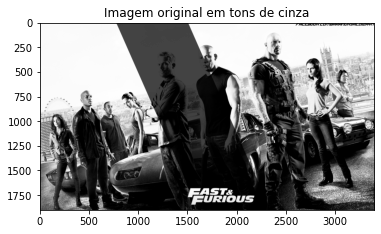

In [14]:
# Importing the image and information about it's dimensions and size

src_img = cv2.imread('foda.png', 0)
src_img_size = os.stat('foda.png').st_size

print("Dimensões da imagem: {}x{}".format(src_img.shape[1], src_img.shape[0]))
print("Tamanho da imagem (em disco): {} MB / {} kB".format(src_img_size/10 ** 6, src_img_size/10 ** 3))

plt.title("Imagem original em tons de cinza")
plt.imshow(src_img, cmap="gray")

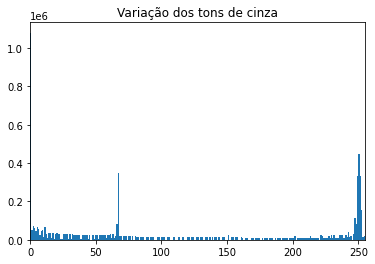

In [15]:
# Histogram with image gray levels
padded_img = pad_img(src_img)
flattered_img = padded_img.ravel()

plt.hist(flattered_img, 256, [0,255]);
plt.xlim([0, 255])
plt.title("Variação dos tons de cinza")
plt.show()

## Primeiro método de Compressão
Transformada Discreta do Cosseno + Quantização através da tabela padrão utilizada pelo JPEG + Codificação através de prefixos de 0

In [17]:
# Function that receives a SQ x SQ block and applies DCT Transform + Quantization

# Function to transform any number smaller than 2^32 into a 8bit array
def num_to_array(num):
    bits     = [1 if (num & (1 << i)) else 0 for i in range(32)]
    
    response = []
    for i in range(4):
        cur_num = 0
        for j in range(8):
            if(bits[i*8 + j]):
                cur_num += (1 << j)
        response.append(cur_num)
    
    return response

def array_to_num(arr):
    bits = []
    for i in range(4):
        for j in range(8):
            if(arr[i] & (1 << j)):
                bits.append(1)
            else:
                bits.append(0)
    
    num = 0
    for i in range(32):
        if(bits[i]):
            num += (1 << i)
    
    return num
    
def apply_dct(block):
    image = block.copy()
    
    image -= 128
    image =  image.astype(float)
    return cv2.dct(image)

def apply_idct(block):
    image = block.copy()
    image =  image.astype(float)
    image = cv2.idct(image)
    image += 128
    return image

# Used to guarantee consistent numbers in simple array
def f(num):
    if num == 128:
        return 126
    if num == 127:
        return 126
    
    return num

def desimplify_block(block):
    desimple = []
    line     = []
    for num in block:
        if num == 128:
            break
        elif num == 127:
            line += [0 for i in range(SQ - len(line))]
            desimple.append(line)
            line = []
        else:
            line.append(num)
            
    # Padding
    for i in range(SQ - len(desimple)):
        desimple.append([0] * 8)
    
    return np.array(desimple)

# 127  is used to store line ending
# 128 is used to store block ending
def simplify_block(block):
    simple = []
    for i in range(SQ):
        # Transform line
        line = []
        for j in reversed(range(SQ)):
            if line:
                line.append(f(block[i][j]))
            elif(block[i][j] != 0):
                line.append(127)
                line.append(f(block[i][j]))
        
        line.reverse()
        simple += line
    
    simple.append(128)
    
    return simple
    
def encode_block(block):
    local_dct        = apply_dct(block)
    local_quant      = local_dct / quant_matrix
    local_quant      = local_quant.round()
    
    return simplify_block(local_quant)

def decode_block(block):
    local_block = desimplify_block(block)
    
    return apply_idct(local_block * quant_matrix)

def encode_img(img):
    # Adding dimensions to start of array
    xshape, yshape = img.shape
    encoded = num_to_array(xshape) + num_to_array(yshape)
    
    padded_img = pad_img(img)
    
    lin = padded_img.shape[0]
    col = padded_img.shape[1]
    for l in tqdm(range(0, lin, SQ)):
        for c in range(0, col, SQ):
            encoded += encode_block(padded_img[l:l+SQ, c:c+SQ])
    
    return np.array(encoded, dtype=np.int8)
    
def decode_img(img):
    pass

In [19]:
foda_coded = encode_img(src_img)

100%|█████████████████████████████████████████| 238/238 [00:03<00:00, 67.75it/s]


In [20]:
np.save('results/foda_coded.npy', foda_coded) 

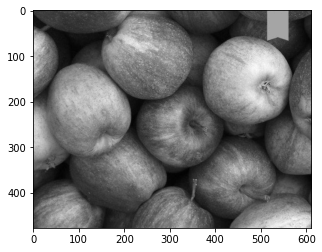

In [217]:
plt.imshow(src_img, cmap="gray")

RMSE: 4.200867755462763
PSNR: 35.6640234079444


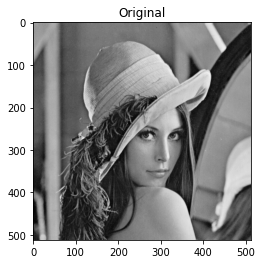

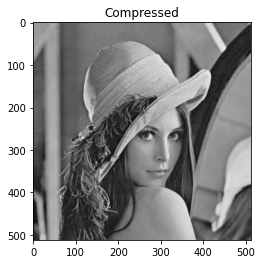

In [186]:
# Iterating
padded_img_shape = padded_img.shape

lin = padded_img_shape[0]
col = padded_img_shape[1]

dct_full = np.zeros(padded_img_shape)
encoded  = []

for l in range(0, lin, SQ):
    for c in range(0, col, SQ):
        dct_full[l:l+SQ, c:c+SQ] = decode_block(encode_block(padded_img[l:l+SQ, c:c+SQ]))
        encoded += encode_block(padded_img[l:l+SQ, c:c+SQ])
        

plt.title("Original")
plt.imshow(padded_img, cmap="gray",)
plt.figure()

plt.title("Compressed")
plt.imshow(dct_full, cmap="gray")

print("RMSE:", rmse(padded_img, dct_full))
print("PSNR:", psnr(padded_img, dct_full))
# print("Taxa de Compressão:", compression_rate(padded_img, dct_full))

In [187]:
encoded

[16.0,
 127,
 1.0,
 127,
 128,
 16.0,
 2.0,
 127,
 1.0,
 127,
 128,
 14.0,
 1.0,
 -0.0,
 -1.0,
 127,
 1.0,
 127,
 128,
 13.0,
 -0.0,
 1.0,
 127,
 128,
 15.0,
 -2.0,
 1.0,
 127,
 1.0,
 -0.0,
 -1.0,
 127,
 128,
 21.0,
 -2.0,
 -1.0,
 127,
 128,
 20.0,
 3.0,
 -1.0,
 127,
 128,
 2.0,
 11.0,
 -1.0,
 -0.0,
 -1.0,
 127,
 1.0,
 0.0,
 -1.0,
 -1.0,
 127,
 128,
 -17.0,
 -0.0,
 2.0,
 127,
 1.0,
 127,
 -1.0,
 127,
 128,
 -12.0,
 -2.0,
 127,
 1.0,
 1.0,
 127,
 128,
 -11.0,
 -0.0,
 1.0,
 127,
 1.0,
 127,
 128,
 -11.0,
 -1.0,
 127,
 1.0,
 127,
 128,
 -11.0,
 127,
 1.0,
 1.0,
 127,
 128,
 -7.0,
 -2.0,
 127,
 128,
 -3.0,
 -1.0,
 -1.0,
 127,
 -1.0,
 127,
 128,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 127,
 1.0,
 127,
 128,
 1.0,
 1.0,
 127,
 128,
 2.0,
 1.0,
 127,
 1.0,
 1.0,
 127,
 128,
 1.0,
 -0.0,
 0.0,
 1.0,
 127,
 128,
 2.0,
 -1.0,
 127,
 128,
 3.0,
 -1.0,
 127,
 128,
 3.0,
 127,
 128,
 2.0,
 1.0,
 127,
 128,
 2.0,
 127,
 1.0,
 127,
 128,
 3.0,
 127,
 1.0,
 127,
 128,
 3.0,
 1.0,
 127,
 1.0,
 127,
 128,
 3.0,
 1.

## Segundo método de Compressão
Codificação Preditiva do Erro com Perdas + Codificação de Huffman para reduzir a redundância de código e salvar menos bytes em disco.

In [7]:
# Variables and auxiliar functions

quantization_level = 4

def preditive_encode(img):
    preditive = img.copy()
    
    for i in range(0, lin):
        for j in range(0, col):
            if(j != 0):
                preditive[i, j] -= preditive[i, j - 1]
                
    return preditive

def preditive_decode(preditive):
    img = preditive.copy()
    
    for i in range(0, lin):
        for j in range(0, col):
            if(j != 0):
                img[i, j] += preditive[i, j - 1]
                
    return img

# def quantizate(matrix):
#     quantizated = matrix.copy()
    
#     for i in range(0, quantizated.shape[0]):
#         for j in range(0, quantizated.shape[1]):
#             if(quantizated[i, j] % quantization_level):
                
                
#     return quantizated

In [8]:
class Node:
    def __init__(self):
        self.prob = None
        self.code = None
        self.data = None
        self.left = None
        self.right = None
    def __lt__(self, other):
        if (self.prob < other.prob):
            return 1
        else:
            return 0
    def __ge__(self, other):
        if (self.prob > other.prob):
            return 1
        else:
            return 0

def tree(probabilities):
    prq = queue.PriorityQueue()
    for color,probability in enumerate(probabilities):
        leaf = Node()
        leaf.data = color
        leaf.prob = probability
        prq.put(leaf)

    while (prq.qsize()>1):
        newnode = Node()
        l = prq.get()
        r = prq.get()
        newnode.left = l
        newnode.right = r
        newprob = l.prob+r.prob
        newnode.prob = newprob
        prq.put(newnode)
    return prq.get()

def huffman_traversal(root_node, tmp_array, huffman_dict):
    if (root_node.left is not None):
        tmp_array[huffman_traversal.count] = 1
        huffman_traversal.count+=1
        huffman_traversal(root_node.left,tmp_array,huffman_dict)
        huffman_traversal.count-=1
    if (root_node.right is not None):
        tmp_array[huffman_traversal.count] = 0
        huffman_traversal.count+=1
        huffman_traversal(root_node.right,tmp_array,huffman_dict)
        huffman_traversal.count-=1
    else:
        huffman_traversal.output_bits[root_node.data] = huffman_traversal.count
        bitstream = ''.join(str(cell) for cell in tmp_array[1:huffman_traversal.count]) 
        color = str(root_node.data)
        huffman_dict[color] = bitstream
    return

def huffman_encode(img):
    hist = np.bincount(img.ravel(), minlength=256)
    probabilities = hist / np.sum(hist)

    root_node = tree(probabilities)
    tmp_array = np.ones([64],dtype=int)
    huffman_traversal.output_bits = np.empty(256, dtype = 'uint8') 
    huffman_traversal.count = 0

    huffman_dict = {}
    huffman_traversal(root_node, tmp_array, huffman_dict)
    
    return huffman_dict

In [26]:
# preditive_matrix = preditive_encode(padded_img)     
# quantizated = quantizate(preditive_matrix)

# Compressing the image

huffman_dict = huffman_encode(padded_img)

coded_img = padded_img.copy()

for i in range(0, coded_img.shape[0]):
    for j in range(0, coded_img.shape[1]):
        coded_img[i, j] = int(huffman_dict[str(coded_img[i, j])], 2)
        
file = open("compressed.qocm", "w")

file.write('{}x{}\n'.format(padded_img.shape[0], padded_img.shape[1]))
file.write(str(huffman_dict))

file.write('\n')

for row in coded_img:
    np.savetxt(file, row, fmt='%i')
    
file.close()

In [28]:
# Uncompressing the image

file = open("compressed.qocm", "r")

dimensions = file.readline()
dimensions = dimensions.split('x')
dimensions = [int(i) for i in dimensions]

huffman_dict = file.readline()
huffman_dict = ast.literal_eval(huffman_dict)

raw_img = np.loadtxt(file).reshape(dimensions[0], dimensions[1])
raw_img = raw_img.astype(int)

file.close()

decoded_img = raw_img.copy()
decoded_img = decoded_img.astype(int)

reverse_dict = dict(zip(huffman_dict.values(), huffman_dict.keys()))

for i in range(0, dimensions[0]):
    for j in range(0, dimensions[1]):
        decoded_img[i, j] = reverse_dict[format(decoded_img[i, j], "b")]
        
# decoded_matrix = preditive_decode(preditive_matrix)
                
plt.title("Original")
plt.imshow(padded_img, cmap="gray",)
plt.figure()

plt.title("Compressed")
plt.imshow(decoded_img, cmap="gray")

print("RMSE:", rmse(padded_img, decoded_img))
print("PSNR:", psnr(padded_img, decoded_img))

KeyError: '11111'

## Terceiro método de compressão
Compressão baseado na Decomposição em Valores Singulares

In [19]:
def svd_compression(img):
    U, sigma, V = np.linalg.svd(img, full_matrices=False) # calcula o U, V e os valores singulares da imagem
    
    rank = len(sigma)
    
    k = round(0.5 * rank)
        
    U_new = U[:,:k] # colunas menores que k de U
    V_new = V[:k,:] # colunas menores que k de V
    S_new = np.zeros((k, k), int) # matriz com os maiores k elementos da diagonal
    
    for i in range(k):
        S_new[i][i] = sigma[i]
        
    file = open("results/compressed_svd.bin" ,"wb")
    
    np.save(file, U_new)
    np.save(file, S_new)
    np.save(file, V_new)
    
    file.close()

def svd_decompression():
    file = open("results/compressed_svd.bin" ,"rb")
    
    U = np.load(file)
    sigma = np.load(file)
    V = np.load(file)
    
    file.close()
        
    uncompressed_img = np.dot(np.dot(U, sigma), V) # multiplica as matrizes para calcular a nova imagem
    
    return uncompressed_img

RMSE: 1.176785351890826
PSNR: 46.716858531770555


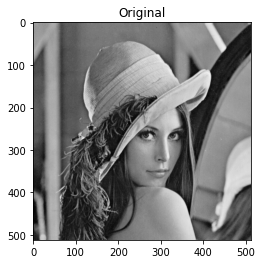

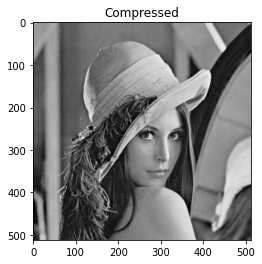

In [20]:
svd_compression(padded_img)

uncompressed_img = svd_decompression()

plt.title("Original")
plt.imshow(padded_img, cmap="gray",)
plt.figure()

plt.title("Compressed")
plt.imshow(uncompressed_img, cmap="gray")

print("RMSE:", rmse(padded_img, uncompressed_img))
print("PSNR:", psnr(padded_img, uncompressed_img))